# 누적관객수 Top 11 영화들에 대한 각종 점유율 분석

## 필요 패키지

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from datetime import date
import os

## 데이터 파일 불러오기 및 전처리

In [2]:
# 이용하는 함수 모음 클래스
class movie_functions():
    movies = []
    file_names = os.listdir("./boxofficeFiles/top11_screen")

    # 파일 불러오는 함수
    def get_file(self):
        for file_name in self.file_names:
            # 엑셀 파일 불러오기
            temp = pd.read_excel(f"./boxofficeFiles/top11_screen/{file_name}")
            # 컬럼명 재설정 및 쓸데없는 행 제거
            temp.columns = temp.loc[2,:]
            temp.columns.name = file_name[0:-4]
            temp.drop([0,1,2], inplace=True)
            temp.reset_index(drop=True, inplace=True)
            # 날짜 컬럼에서 시간 제거
            for i in range(len(temp)):
                temp.loc[i,"날짜"] = temp.loc[i,"날짜"].date()
            # 영화 리스트에 추가
            self.movies.append(temp)
    
    # 개봉년도와 그 다음년도 이후의 데이터는 재개봉으로 판단하여 제외하는 함수
    def remove_outlier_year(self, df):
        overindex= []
        for i in range(len(df)):
            if (df.loc[i, "날짜"].year <= (df.loc[0, "날짜"].year + 1)):
                overindex.append(i)
        df = df.loc[overindex,:]
        return df
    
    def remove_year(self):
        for i in range(len(self.movies)):
            self.movies[i] = self.remove_outlier_year(self.movies[i])

    # 스크린수가 100개 미만인 경우는 전체 누적관객수에 영향이 거의 없으므로 제외하는 함수
    def remove_under100(self):
        for i in range(len(self.movies)):
            self.movies[i] = self.movies[i].loc[self.movies[i]["스크린수"] > 100,:]
            self.movies[i].reset_index(drop=True, inplace=True)

    # 점유율들을 100퍼센트 기준으로 변경하기
    def update_shares(self):
        for i in range(len(self.movies)):
            for col in ["스크린점유율", "상영점유율", "좌석점유율", "좌석판매율"]:
                self.movies[i].loc[:,col] = 100 * self.movies[i].loc[:,col]
    
    # 관객수, 매출액 증감 새로운 파생컬럼으로 나누기
    def create_increase_column_sub(self, df):
        for i in range(len(df)):
            df.loc[i,"매출액증감(전일대비)비율"] = float(df.loc[i,"매출액증감(전일대비)"].split()[2][:-1])
            df.loc[i,"매출액증감(전일대비)"] = int(df.loc[i,"매출액증감(전일대비)"].split()[0])
        for i in range(len(df)):
            df.loc[i,"관객수증감(전일대비)비율"] = float(df.loc[i,"관객수증감(전일대비)"].split()[2][:-1])
            df.loc[i,"관객수증감(전일대비)"] = int(df.loc[i,"관객수증감(전일대비)"].split()[0])
        return df
    
    def create_increase_column(self):
        for i in range(len(self.movies)):
            self.movies[i] = self.create_increase_column_sub(self.movies[i])

    # 스크린수 대비 관객수 컬럼 생성
    def create_ratio_sub(self, df):
        df.loc[:,"스크린수대비관객수"] = df.loc[:,"관객수"] / df.loc[:,"스크린수"]
        df.loc[:,"좌석수대비관객수"] = df.loc[:,"관객수"] / df.loc[:,"좌석수"]
        df.loc[:,"스크린점유율대비관객수"] = df.loc[:,"관객수"] / df.loc[:,"스크린점유율"]
        return df

    def create_ratio(self):
        for i in range(len(self.movies)):
            self.movies[i] = self.create_ratio_sub(self.movies[i])

    # 직선 그래프 그리는 함수
    def lineplotting(self, column, show_movies=[]):
        if show_movies == []:
            show_movies = [df.columns.name for df in self.movies]
        show_movies = list(np.sort(show_movies))
        plt.rcParams['font.family'] = 'Malgun Gothic'
        fig = plt.figure(figsize=(20,10))
        ax1 = fig.add_subplot(1,1,1)
        for i in range(len(self.movies)):
            if self.movies[i].columns.name in show_movies:
                sns.lineplot(self.movies[i].index, self.movies[i][column], ax = ax1)
        plt.legend(show_movies)
        plt.show()


In [3]:
# 클래스 선언 및 파일 불러오기
mf = movie_functions()
mf.get_file()

In [4]:
# 각각 NA값 확인
for i in range(len(mf.movies)):
    print(f"{mf.movies[i].columns.name}:{mf.movies[i].isna().sum().sum()}")

7번방의선물:0
광해:0
극한직업:0
기생충:0
도둑들:0
명량:0
베테랑:0
부산행:0
신과함께-인과연:0
암살:0
택시운전사:0


In [5]:
# 필요없는 년도 제외하기
mf.remove_year()

In [6]:
# 스크린수 100개 이하 제외하기
mf.remove_under100()

In [7]:
# 점유율 100퍼센트 단위로 바꾸기
mf.update_shares()

In [8]:
# 증감에 대한 파생컬럼 생성하기
mf.create_increase_column()

In [9]:
# 스크린수, 좌석수, 스크린점유율 대비 관객수 컬럼 생성
mf.create_ratio()

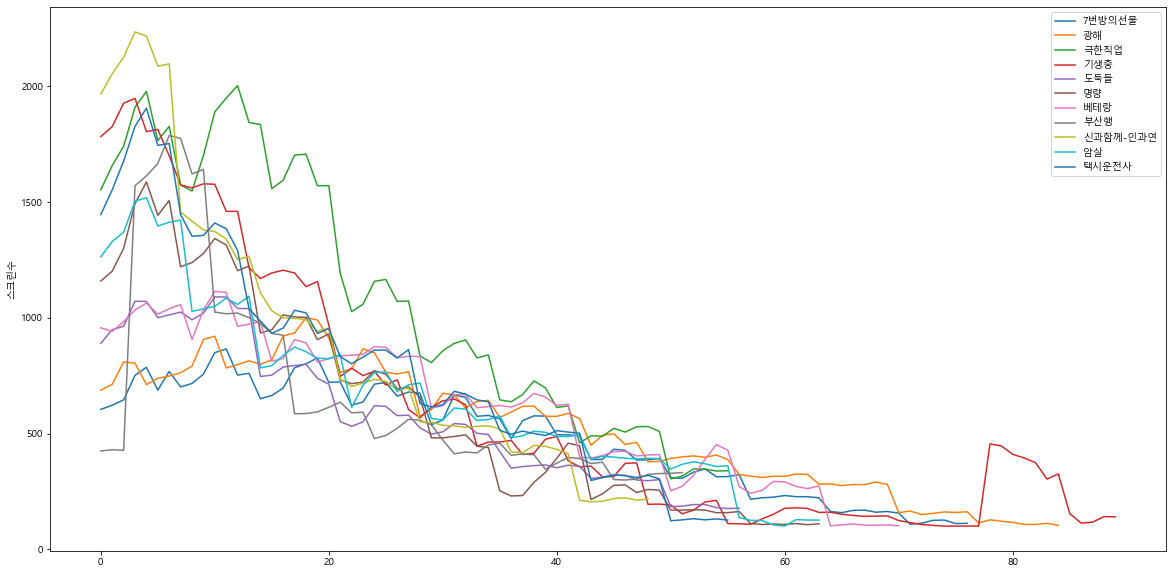

In [10]:
mf.lineplotting("스크린수")

- 부산행의 경우 개봉전 시사회 때의 스크린수가 400이상이기 때문에 개봉일 3일 전부터가 들어가 있음(제외하고 생각할 것)

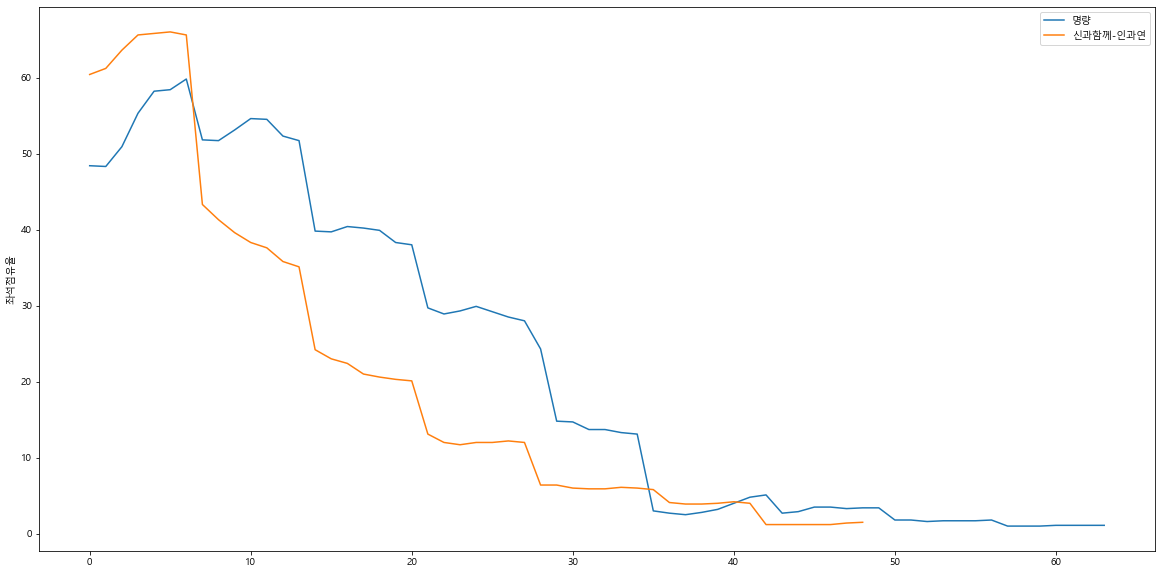

In [11]:
mf.lineplotting("좌석점유율", ["명량", "신과함께-인과연"])

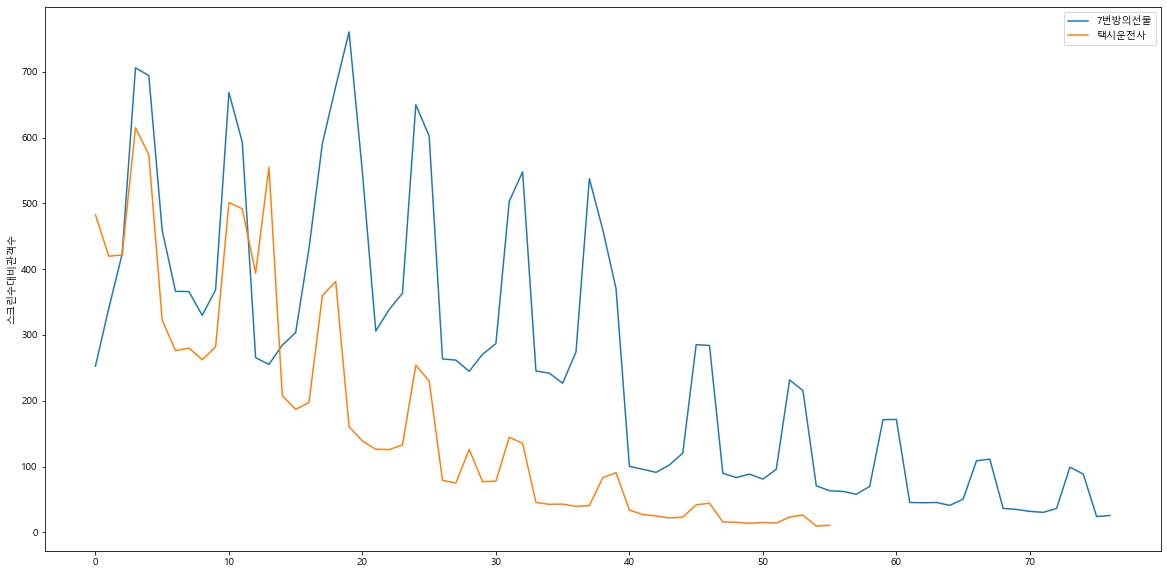

In [14]:
mf.lineplotting("스크린수대비관객수", ["택시운전사", "7번방의선물"])

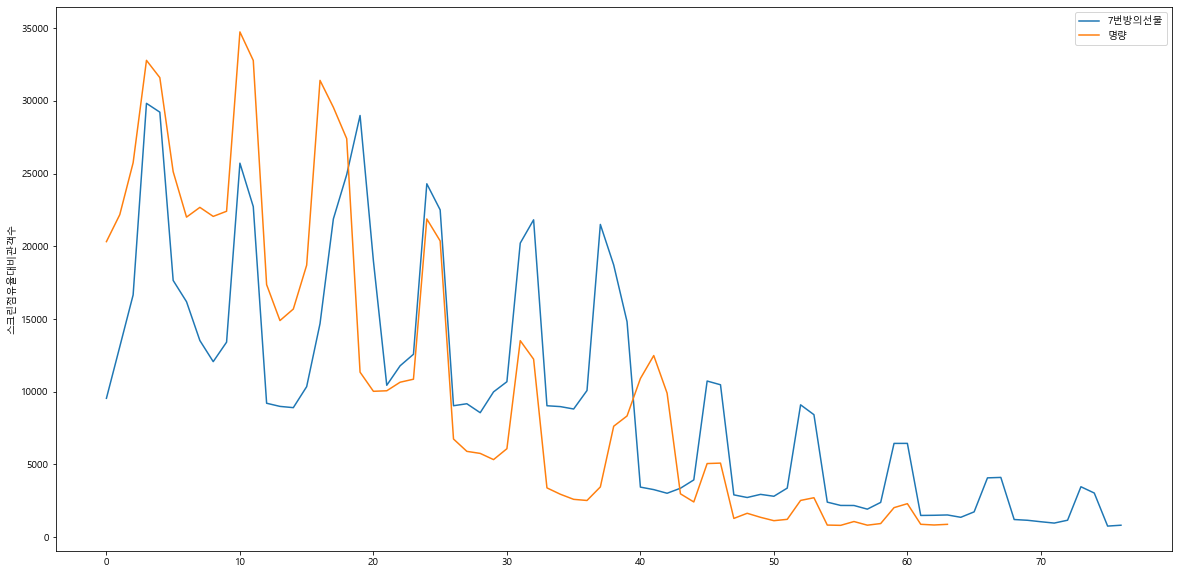

In [18]:
mf.lineplotting("스크린점유율대비관객수", ["7번방의선물", "명량"])

In [13]:
mf.movies[0]

7번방의선물,날짜,스크린수,스크린점유율,상영횟수,상영점유율,좌석수,좌석점유율,좌석판매율,매출액,매출액증감(전일대비),관객수,관객수증감(전일대비),누적매출액,누적관객수,순위,매출액증감(전일대비)비율,관객수증감(전일대비)비율,스크린수대비관객수,좌석수대비관객수,스크린점유율대비관객수
0,2013-01-23,605,16.0,2874,22.4,602838,27.1,25.3,1066485000,999641000,152808,142082,1238120000,177508,1,1495.5,1324.7,252.575207,0.253481,9550.5
1,2013-01-24,623,16.2,2989,22.9,635671,28.0,33.4,1473455500,406970500,212148,59340,2711575500,389656,1,38.2,38.8,340.526485,0.333739,13095.555556
2,2013-01-25,646,16.4,3137,23.4,665355,28.5,41.1,2007309089,533853589,273136,60988,4718884589,662792,1,36.2,28.7,422.811146,0.410512,16654.634146
3,2013-01-26,752,17.8,3452,24.5,719508,29.6,73.8,3941053113,1933744024,530869,257733,8659937702,1193661,1,96.3,94.4,705.942819,0.737822,29824.101124
4,2013-01-27,787,18.7,3490,25.5,725848,30.7,75.3,4039741500,98688387,546386,15517,12699679202,1740047,1,2.5,2.9,694.264295,0.752755,29218.502674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,2013-04-05,113,3.5,301,2.3,36923,1.7,11.1,27771500,7126000,4092,785,91124063170,12762352,10,34.5,23.7,36.212389,0.110825,1169.142857
73,2013-04-06,126,3.6,322,2.3,39520,1.7,31.6,88945000,61173500,12490,8398,91213008170,12774842,6,220.3,205.2,99.126984,0.316043,3469.444444
74,2013-04-07,127,3.7,314,2.4,38916,1.7,28.9,78194500,-10750500,11239,-1251,91291202670,12786081,6,-12.1,-10.0,88.496063,0.288802,3037.567568
75,2013-04-08,112,3.5,281,2.4,34876,1.7,7.7,17729500,-60465000,2679,-8560,91308932170,12788760,9,-77.3,-76.2,23.919643,0.076815,765.428571
